In [1]:
from ica_benchmark.scoring import mutual_information, coherence, correntropy, apply_pairwise, apply_pairwise_parallel, SCORING_FN_DICT
from ica_benchmark.processing.ica import get_ica_transformers
import time
from ica_benchmark.io.load import join_gdfs_to_numpy, load_subjects_data, load_subject_data
from ica_benchmark.processing.label import get_annotations
from mne import find_events, events_from_annotations
from mne.viz import plot_events
from mne.io import read_raw_gdf


In [2]:
from pathlib import Path

root = Path("C:/Users/paull/Documents/GIT/BCI_MsC/notebooks/BCI_Comp_IV_2a/BCICIV_2a_gdf")

subjects =  {
    "A01": [
        "C:\\Users\\paull\\Documents\\GIT\\BCI_MsC\\notebooks\\BCI_Comp_IV_2a\\BCICIV_2a_gdf\\A01E.gdf",
        "C:\\Users\\paull\\Documents\\GIT\\BCI_MsC\\notebooks\\BCI_Comp_IV_2a\\BCICIV_2a_gdf\\A01T.gdf"
    ]
}


In [3]:
data = load_subjects_data(root, subjects)

In [4]:
arr = data["A01"]["gdf"]._data.T
labels = data["A01"]["labels"]
arr.shape, labels.shape

((1359528, 22), (1359528, 11))

In [5]:
from mne.time_frequency import psd_multitaper, tfr_array_multitaper, psd_array_multitaper
import numpy as np
import matplotlib.pyplot as plt
from ica_benchmark.processing.ica import create_gdf_obj

In [7]:
arr = np.expand_dims(arr.T, axis=0)
arr.shape

(1, 22, 1359528)

In [10]:
res = tfr_array_multitaper(arr, 250, np.linspace(1, 12, 12), output="power", n_cycles=3, decim=10)
res = res.squeeze()

In [ ]:
plt.figure(figsize=(30, 5))
plt.imshow(res[0, :, :])

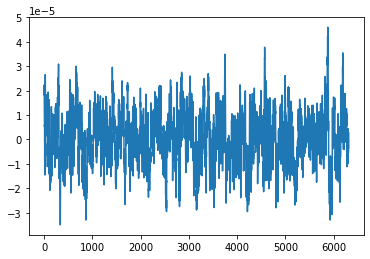

In [14]:
plt.plot(arr[0, 0, :])

In [239]:
from torch.utils.data import IterableDataset, DataLoader
import torch
from statistics import mode

DEFAULT_FREQUENCIES = np.linspace(1, 30, 30)

DEFAULT_TRF_KWARGS = dict(
    sfreq=250.0,
    freqs=DEFAULT_FREQUENCIES, 
#     n_cycles=7.0,
    n_cycles=3.0,
    zero_mean=True,
    time_bandwidth=4,
#     use_fft=True,
    decim=1,
    output='power',
    n_jobs=1,
)

DEFAULT_PSD_KWARGS = dict(
    sfreq=250.0,
    fmin=0,
    fmax=np.inf,
    bandwidth=None,
    verbose=0,
)

def tfr_multitaper(
    arr,
    epochs_mode=False,
    feature_format=None,
    **mne_kwargs
):
    
    if not mne_kwargs:
        mne_kwargs = DEFAULT_TRF_KWARGS
    
    # arr is (n_times, n_channels)
    if not epochs_mode:
        assert arr.ndim == 2, "The input array must be of shape (n_times, n_channels)"
        # to (n_channels, n_times)
        arr = np.expand_dims(arr.T, axis=0)
    else:
        assert arr.ndim == 3, "The input array must be of shape (n_epochs, n_times, n_channels)"
        # to (n_epochs, n_channels, n_times)
        arr = arr.transpose(0, 2, 1)
    
    # input (n_epochs, n_channels, n_times)
    tfr_psd = tfr_array_multitaper(
        arr,
        **mne_kwargs
    )
    # output = (n_epochs, n_chans, n_freqs, n_times)
    
    if feature_format is None:
        return tfr_psd
    
    n_epochs, n_chans, n_freqs, n_times = tfr_psd.shape
    if feature_format:
        #(n_epochs, n_chans, n_freqs, n_times) -> (size, features)
        tfr_psd = tfr_psd\
            .transpose(0, 3, 1, 2)\
            .reshape(n_epochs, n_times, n_chans * n_freqs)
    else:
        tfr_psd = tfr_psd.transpose(0, 3, 1, 2)
        
    tfr_psd = tfr_psd.squeeze() if n_epochs == 1 else tfr_psd
    
    return tfr_psd

def psd_multitaper(
    arr,
    **mne_kwargs
    ):

    if not mne_kwargs:
        mne_kwargs = DEFAULT_PSD_KWARGS

    psd, freqs = psd_array_multitaper(
        arr.T,
        **mne_kwargs
    )
    psd = np.expand_dims(psd.T, axis=0)
    
    return psd, freqs

def with_default(value, default):
    return value if value is not None else default

class WindowTransformer():

    def __init__(
        self,
        feature_transform_fn,
        label_transform_fn=mode,
        window_size=250,
        stride=125,
        iterator_mode=False,
        ):

        self.feature_transform_fn = feature_transform_fn
        self.label_transform_fn = label_transform_fn
        self.window_size = window_size
        self.stride = stride
        self.iterator_mode = iterator_mode

    def transform(self, x, y=None, start=None, end=None):
        
        size = len(x)
        start, end = with_default(start, 0), with_default(end, size)

        if y is not None:
            assert len(x) == len(y), "X and Y must have same sizes"

        if self.iterator_mode:
            return self._transform_iter(x, y=y, start=start, end=end)
        else:
            return self._transform_list(x, y=y, start=start, end=end)

    def _transform_list(self, x, y=None, start=None, end=None):
        
        with_y = y is not None

        output_x, output_y = list(), list()

        for step in range(start, end, self.stride):

            if step + self.window_size > end:
                break

            item_x = self.feature_transform_fn(x[step : step + self.window_size])
            if with_y:
                item_y = self.label_transform_fn(y[step : step + self.window_size])
            else:
                item_y = None

            return_items = item_x if with_y else (item_x, item_y)

            output_x.append(item_x)
            output_y.append(item_y)
        
        output_x = np.concatenate(output_x, axis=0)

        if with_y:
            output_y = np.array(output_y)

        return (output_x, output_y) if with_y else output_x

    def _transform_iter(self, x, y=None, start=None, end=None):
        
        with_y = y is not None
        
        if y is not None:
            assert len(x) == len(y), "X and Y must have same sizes"

        output_x, output_y = list(), list()

        for step in range(start, end, self.stride):

            if step + self.window_size > end:
                break

            item_x = self.feature_transform_fn(x[step : step + self.window_size])
            if with_y:
                item_y = self.label_transform_fn(y[step : step + self.window_size])
            else:
                item_y = None

            return_items = (item_x, item_y) if with_y else item_x

            yield return_items


class TFRDataset(IterableDataset):
    def __init__(self, arr, start=None, end=None, window_size=250, stride=125):
        super(TFRDataset).__init__()
        
        if start is None:
            start = 0
        if end is None:
            end = len(arr)
        
        assert end > start, "this example code only works with end >= start"

        self.start = start
        self.end = end
        self.arr = arr
        self.labels = labels
        self.window_size = window_size
        self.stride = stride

    def __iter__(self):
        worker_info = torch.utils.data.get_worker_info()
        if worker_info is None:  # single-process data loading, return the full iterator
            iter_start = self.start
            iter_end = self.end
        else:  # in a worker process
            # split workload
            per_worker = int(np.ceil((self.end - self.start) / float(worker_info.num_workers)))
            worker_id = worker_info.id
            iter_start = self.start + worker_id * per_worker
            iter_end = min(iter_start + per_worker, self.end)

        feature_iter = window_gen(
            self.arr,
            start = iter_start,
            end = iter_end,
            window_size = self.window_size,
            stride = self.stride
        )
        
        return feature_iter

In [240]:
arr = np.random.rand(10000, 5)
label = np.random.randint(0, 10, 10000)
# tfr_multitaper(arr, epochs_mode=False, iter_mode=).shape, psd_multitaper(arr)[1].shape
f_trans = lambda x: psd_multitaper(x)[0]
transformer = WindowTransformer(feature_transform_fn=f_trans, window_size=1000, stride=500, iterator_mode=False)
a, b = transformer.transform(arr, label)

In [242]:
a.shape

(19, 501, 5)

In [20]:
psd_array_multitaper(arr.T, sfreq=250, fmin=10, fmax=124)[0].shape


(5, 13681)

In [22]:
a = np.sin(np.linspace(-10, 10, 1000)).reshape(1, -1) + np.sin(5 * np.linspace(-10, 10, 1000)).reshape(1, -1) + np.sin(15 * np.linspace(-10, 10, 1000)).reshape(1, -1)
psd, freqs = psd_array_multitaper(a, sfreq=250, fmax=30)
# psd.shape

In [23]:
freqs

array([ 0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,  1.75,  2.  ,
        2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,  4.  ,  4.25,
        4.5 ,  4.75,  5.  ,  5.25,  5.5 ,  5.75,  6.  ,  6.25,  6.5 ,
        6.75,  7.  ,  7.25,  7.5 ,  7.75,  8.  ,  8.25,  8.5 ,  8.75,
        9.  ,  9.25,  9.5 ,  9.75, 10.  , 10.25, 10.5 , 10.75, 11.  ,
       11.25, 11.5 , 11.75, 12.  , 12.25, 12.5 , 12.75, 13.  , 13.25,
       13.5 , 13.75, 14.  , 14.25, 14.5 , 14.75, 15.  , 15.25, 15.5 ,
       15.75, 16.  , 16.25, 16.5 , 16.75, 17.  , 17.25, 17.5 , 17.75,
       18.  , 18.25, 18.5 , 18.75, 19.  , 19.25, 19.5 , 19.75, 20.  ,
       20.25, 20.5 , 20.75, 21.  , 21.25, 21.5 , 21.75, 22.  , 22.25,
       22.5 , 22.75, 23.  , 23.25, 23.5 , 23.75, 24.  , 24.25, 24.5 ,
       24.75, 25.  , 25.25, 25.5 , 25.75, 26.  , 26.25, 26.5 , 26.75,
       27.  , 27.25, 27.5 , 27.75, 28.  , 28.25, 28.5 , 28.75, 29.  ,
       29.25, 29.5 , 29.75, 30.  ])

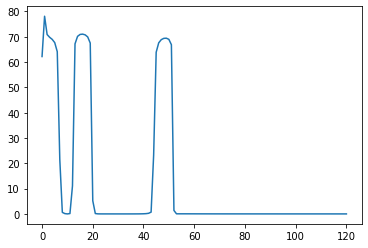

In [154]:
plt.plot(psd[0, :])

In [139]:
freqs

array([0.00000000e+00, 8.33333333e-03, 1.66666667e-02, ...,
       1.24983333e+02, 1.24991667e+02, 1.25000000e+02])